# Trained on Full Image - Infer on whole 3D but stack 2D slices.

In [1]:
def calc_dice(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    numerator = 2.0 * np.sum(np.round(y_true)*np.round(y_pred))
    denominator = np.sum(np.round(y_true)) + np.sum(np.round(y_pred))
    if denominator == 0:
       return 1.0
    else:
       return numerator / denominator

def calc_slicewise_average_dice(y_true_all, y_pred_all):
    
    num_slices = y_true_all.shape[0]
    dice_slice = np.zeros((num_slices))
    
    for idx in range(num_slices):
        
        y_true = y_true_all[idx].flatten()
        y_pred = y_pred_all[idx].flatten()

        numerator = 2.0 * np.sum(np.round(y_true)*np.round(y_pred))
        denominator = np.sum(np.round(y_true)) + np.sum(np.round(y_pred))
        if denominator == 0:
           dice_slice[idx] = 1.0
        else:
           dice_slice[idx] = numerator / denominator
        
    return np.mean(dice_slice)

def calc_soft_dice(y_true, y_pred, smooth=1):
    """
    Sorensen Dice coefficient
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    numerator = 2.0 * np.sum(y_true * y_pred) + smooth
    denominator = np.sum(y_true) + np.sum(y_pred) + smooth
    coef = numerator / denominator

    return coef

def soft_dice_coef(target, prediction, axis=(1, 2), smooth=0.01):
    """
    Sorenson (Soft) Dice  - Don't round the predictions
    \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
    where T is ground truth mask and P is the prediction mask
    """

    intersection = tf.reduce_sum(target * prediction, axis=axis)
    union = tf.reduce_sum(target + prediction, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coef = numerator / denominator

    return tf.reduce_mean(coef)

def dice_coef(y_true, y_pred, axis=(1, 2), smooth=1):
    """
    Sorenson (Soft) Dice
    \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
    where T is ground truth mask and P is the prediction mask
    """
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true + y_pred, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coef = numerator / denominator

    return tf.reduce_mean(coef)


def dice_coef_loss(target, prediction, axis=(1, 2), smooth=1.):
    """
    Sorenson (Soft) Dice loss
    Using -log(Dice) as the loss since it is better behaved.
    Also, the log allows avoidance of the division which
    can help prevent underflow when the numbers are very small.
    """
    intersection = tf.reduce_sum(prediction * target, axis=axis)
    p = tf.reduce_sum(prediction, axis=axis)
    t = tf.reduce_sum(target, axis=axis)
    numerator = tf.reduce_mean(intersection + smooth)
    denominator = tf.reduce_mean(t + p + smooth)
    dice_loss = -tf.log(2.*numerator) + tf.log(denominator)

    return dice_loss


def combined_dice_ce_loss(y_true, y_pred, axis=(1, 2), smooth=1.,
                          weight=0.9):
    """
    Combined Dice and Binary Cross Entropy Loss
    """
    return weight*dice_coef_loss(y_true, y_pred, axis, smooth) + \
        (1-weight)*K.losses.binary_crossentropy(y_true, y_pred)


def plot_results(imgs_validation, msks_validation, pred_validation, slice_no, filename):
    """
    Plot the predictions for slice_no
    """
    
    import matplotlib.gridspec as gridspec
    
    import ntpath
    filename = ntpath.basename(filename)


    gs1 = gridspec.GridSpec(2, 4)
    gs1.update(wspace=0.2, hspace=0.005) # set the spacing between axes. 


    img = imgs_validation[[slice_no], ]
    msk = msks_validation[[slice_no], ]
    
    pred_mask = pred_validation[[slice_no], ]
   
    
    dice_score = calc_dice(pred_mask, msk)
    
    
    
    plt.figure(figsize=(20,15))
    plt.subplot(gs1[0])
    plt.imshow(img[0,:,:,0], cmap="bone", origin="lower")
    plt.title("MRI\n{}".format(filename), fontsize=18)
    
    plt.subplot(gs1[1])
    plt.imshow(msk[0,:,:,0], origin="lower", cmap="gray")
    plt.title("Ground truth", fontsize=18)
    
    plt.subplot(gs1[2])
    plt.imshow(pred_mask[0,:,:,0], origin="lower", cmap="gray")
    plt.title("Prediction\nDice = {:.4f}".format(dice_score), fontsize=18)
    
    plt.subplot(gs1[3])
    plt.imshow(msk[0,:,:,0]-pred_mask[0,:,:,0], cmap="gray", origin="lower")
    plt.title("Difference", fontsize=18)
    
    plt.subplot(gs1[4])
    plt.imshow(img[0,:,:,0], cmap="bone", origin="lower")
    plt.title("MRI\n{}".format(filename), fontsize=18)
    
    plt.subplot(gs1[5])
    plt.imshow(msk[0,:,:,0], origin="lower", cmap="gray", )
    plt.title("Ground truth", fontsize=18)
   
    
    

In [2]:
!pwd

/home/bduser/ravi/unet-ravi/2D


In [3]:
def plot_tiles(pred_validation_middle, pred_validation_tl, pred_validation_tr, 
               pred_validation_bl, pred_validation_br, slice_no, filename):

    import matplotlib.gridspec as gridspec
    
    import ntpath
    filename = ntpath.basename(filename)


    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(wspace=0.001, hspace=-0.02) # set the spacing between axes. 
    
    
    plt.figure(figsize=(20,15))
    
    # Remember that we flip the image to show it in the correct orientation
    
    plt.subplot(gs1[0])
    plt.imshow(pred_validation_bl[slice_no,:,:,0], origin="lower", cmap="gray")
    
    plt.subplot(gs1[2])
    plt.imshow(pred_validation_br[slice_no,:,:,0], origin="lower", cmap="gray")
    
    plt.subplot(gs1[4])
    plt.imshow(pred_validation_middle[slice_no,:,:,0], origin="lower", cmap="gray")
    plt.title("{}".format(filename), fontsize=18)
    
    plt.subplot(gs1[6])
    plt.imshow(pred_validation_tl[slice_no,:,:,0], origin="lower", cmap="gray")
    
    plt.subplot(gs1[8])
    plt.imshow(pred_validation_tr[slice_no,:,:,0], origin="lower", cmap="gray")
    
    

In [4]:
import os

import numpy as np
import tensorflow as tf
import keras as K
import settings
import argparse
import h5py
import nibabel as nib

import matplotlib.pyplot as plt

args = argparse.Namespace()
args.data_path="/home/bduser/tony/data/decathlon/Task01_BrainTumour/"
args.output_path="/home/bduser/tony/unet_tiling/"
#args.inference_filename="unet_decathlon_4_8814_128x128_randomcrop.hdf5"
#args.inference_filename="unet_decathlon_4_8814_128x128_randomcrop-any-input.h5"
args.inference_filename="unet_decathlon_240x240_dice0820.hdf5"
args.intraop_threads=5
args.interop_threads=2

CONFIG = tf.ConfigProto(
    inter_op_parallelism_threads=args.interop_threads,
    intra_op_parallelism_threads=args.intraop_threads)

SESS = tf.Session(config=CONFIG)
K.backend.set_session(SESS)

model_fn = os.path.join(args.output_path, args.inference_filename)


# Load model
model = K.models.load_model(model_fn, custom_objects={
    "combined_dice_ce_loss": combined_dice_ce_loss,
    "dice_coef_loss": dice_coef_loss,
    "soft_dice_coef": soft_dice_coef,
    "dice_coef": dice_coef})



Using TensorFlow backend.


In [6]:
import json
json_filename = os.path.join(args.data_path, "dataset.json")

try:
    with open(json_filename, "r") as fp:
        experiment_data = json.load(fp)
except IOError as e:
    print("File {} doesn't exist. It should be part of the "
          "Decathlon directory".format(json_filename))
        
numFiles = experiment_data["numTraining"]
idxList = np.arange(numFiles)  # List of file indices


np.random.seed(816)
randomIdx = np.random.random(numFiles)  # List of random numbers
# Random number go from 0 to 1. So anything above
# self.train_split is in the validation list.
trainIdx = idxList[randomIdx < 0.85]

listIdx = idxList[randomIdx >= 0.85]
randomIdx = np.random.random(len(listIdx))  # List of random numbers
validateIdx = listIdx[randomIdx >= 0.5]
testIdx = listIdx[randomIdx < 0.5]
        
imgFiles = {}
mskFiles = {}

for idx, fileIdx in enumerate(testIdx):
    imgFiles[idx] = os.path.join(args.data_path,
                                 experiment_data["training"][fileIdx]["image"])
    mskFiles[idx] = os.path.join(args.data_path,
                                 experiment_data["training"][fileIdx]["label"])


In [7]:
(imgFiles.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [8]:
filename = imgFiles[34]

imgs_validation = np.array(nib.load(imgFiles[idx]).dataobj)
imgs_validation = np.transpose(imgs_validation, [2, 1, 0, 3])

msk = np.array(nib.load(mskFiles[idx]).dataobj)
msk[msk > 0] = 1.0
print(msk.shape)
msk = np.expand_dims(msk, -1)
print(msk.shape)
msks_validation = np.transpose(msk, [2, 1, 0, 3])

(240, 240, 155)
(240, 240, 155, 1)


In [9]:
print("Img val shape:", imgs_validation.shape)
print("Img msk shape:", msks_validation.shape)
msk.shape

Img val shape: (155, 240, 240, 4)
Img msk shape: (155, 240, 240, 1)


(240, 240, 155, 1)

In [10]:
def get_data(idx):
    
    filename = imgFiles[idx]
    imgs_validation = np.array(nib.load(imgFiles[idx]).dataobj)
    imgs_validation = np.transpose(imgs_validation, [2, 1, 0, 3])

    msk = np.array(nib.load(mskFiles[idx]).dataobj)
    msk[msk > 0] = 1.0
    msk = np.expand_dims(msk, -1)

    msks_validation = np.transpose(msk, [2, 1, 0, 3])

   
    return imgs_validation, msks_validation, filename


In [11]:
# 10, 15, 
imgs_validation, msks_validation, filename = get_data(36)

In [12]:
imgs_validation[[1],].shape

(1, 240, 240, 4)

In [13]:
from tqdm import tqdm

def predict(imgs_validation, msks_validation):

    cropx = 128
    cropy = 128
    
    pred_validation = np.zeros_like(msks_validation)

    for img_id in range(imgs_validation.shape[0]):

        full_img = imgs_validation[[img_id], ]
        full_msk = msks_validation[[img_id], ]
        _, x, y, _ = full_img.shape
        
        pred_mask = model.predict(full_img)

        pred_validation[img_id] = pred_mask[0]
        
    return pred_validation

    

In [14]:
%%time
dice_results = []
#for img_file_id in tqdm(range(4)):
for img_file_id in tqdm(imgFiles):
    imgs_validation, msks_validation, filename = get_data(img_file_id)
    pred_validation = predict(imgs_validation, msks_validation)
    
    dice_3d = calc_dice(msks_validation, pred_validation)
    dice_slicewise = calc_slicewise_average_dice(msks_validation, pred_validation)
    
    dice_results.append([img_file_id, dice_3d, dice_slicewise, filename])
    

100%|██████████| 46/46 [04:52<00:00,  6.38s/it]

CPU times: user 2h 8min 24s, sys: 1h 2min 12s, total: 3h 10min 37s
Wall time: 4min 52s


In [16]:
print(dice_results)

[[0, 0.6816967630474613, 0.5960691987886421, '/home/bduser/tony/data/decathlon/Task01_BrainTumour/./imagesTr/BRATS_206.nii.gz'], [1, 0.21078516588585047, 0.28758459594102065, '/home/bduser/tony/data/decathlon/Task01_BrainTumour/./imagesTr/BRATS_017.nii.gz'], [2, 0.745274330424476, 0.6319791901378518, '/home/bduser/tony/data/decathlon/Task01_BrainTumour/./imagesTr/BRATS_074.nii.gz'], [3, 0.1827065925855954, 0.29304371590564643, '/home/bduser/tony/data/decathlon/Task01_BrainTumour/./imagesTr/BRATS_023.nii.gz'], [4, 0.33234009460389846, 0.3925293011789419, '/home/bduser/tony/data/decathlon/Task01_BrainTumour/./imagesTr/BRATS_007.nii.gz'], [5, 0.03402539429943156, 0.14670748719698903, '/home/bduser/tony/data/decathlon/Task01_BrainTumour/./imagesTr/BRATS_176.nii.gz'], [6, 0.8127182628299198, 0.5456124573485571, '/home/bduser/tony/data/decathlon/Task01_BrainTumour/./imagesTr/BRATS_015.nii.gz'], [7, 0.18311005847087558, 0.26166191576365844, '/home/bduser/tony/data/decathlon/Task01_BrainTumour

In [17]:
np.savetxt("dice_res_trained-full_infer-fullimage_imgid_3d-dice_slicewise-dice.csv", dice_results, delimiter=",", fmt="%s")


In [19]:
dice_results = np.asarray(dice_results)
dice_3d = dice_results[:,1]
dice_slicewise = dice_results[:,2]
print("Full Image Inference Results trained on: ", args.inference_filename)
print("Avg of 45 patients' 3D Dice = {:.4f}".format(np.average(dice_3d.astype(float))))
print("Avg of 45 patients' Slicewise Average Dice = {:.4f}".format(np.average(dice_slicewise.astype(float))))

Full Image Inference Results trained on:  unet_decathlon_240x240_dice0820.hdf5
Avg of 45 patients' 3D Dice = 0.4697
Avg of 45 patients' Slicewise Average Dice = 0.5161


In [43]:
np.average(dice_3d.astype(float))

0.5023145191455018

In [49]:
print("3D Dice = {:.4f}".format(calc_dice(msks_validation, pred_validation)))
print("Slicewise Average Dice = {:.4f}".format(calc_slicewise_average_dice(msks_validation, pred_validation)))

3D Dice = 0.2019
Slicewise Average Dice = 0.2747


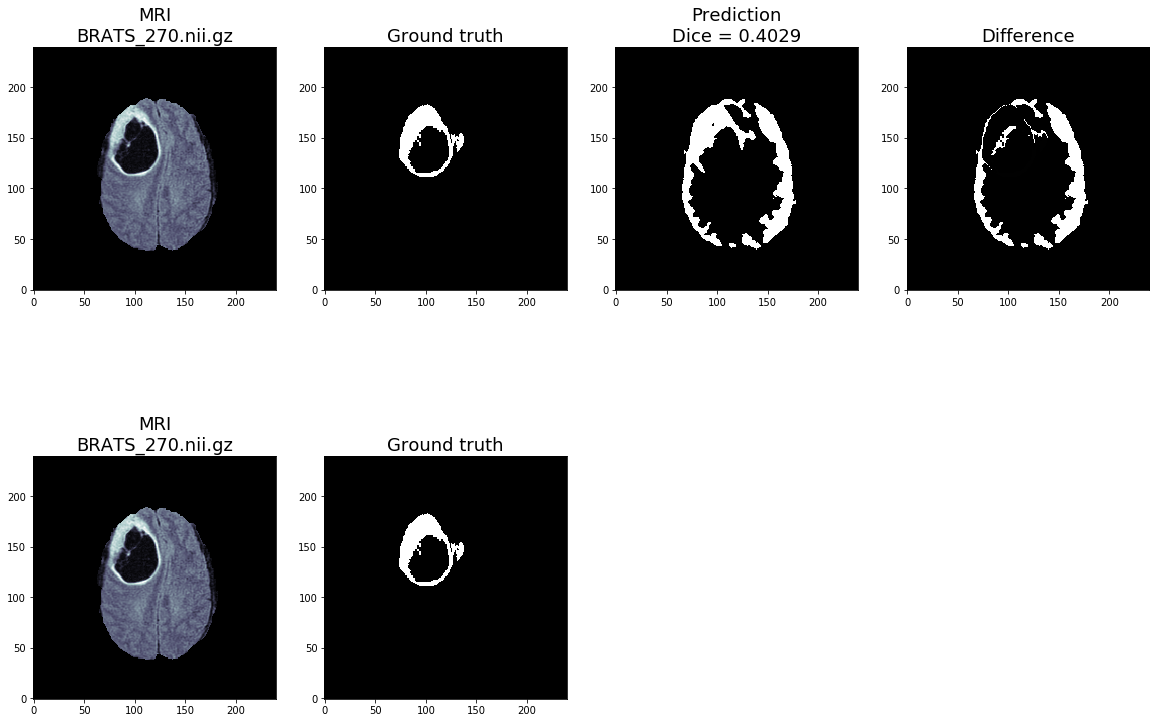

In [51]:
plot_results(imgs_validation, msks_validation, pred_validation, 96, filename)

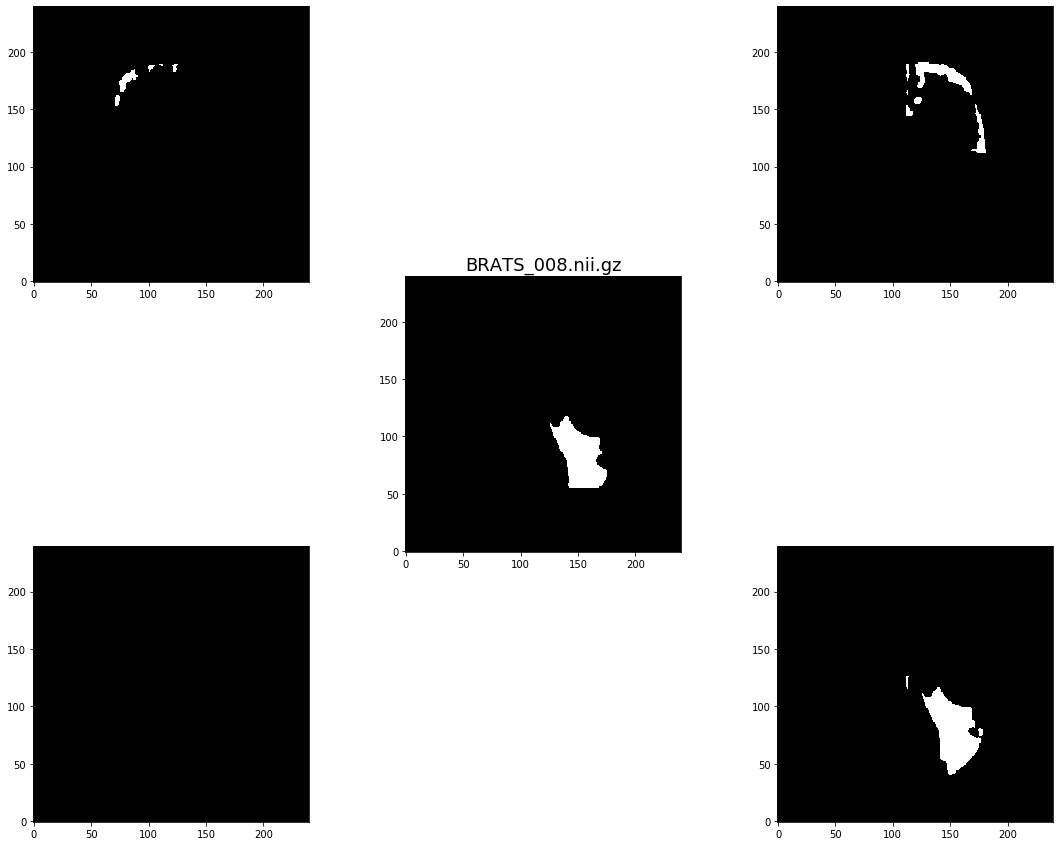

In [64]:
plot_tiles(pred_validation_middle, pred_validation_tl, pred_validation_tr, pred_validation_bl, pred_validation_br, 96, filename)